In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import os
from textblob import TextBlob
from nltk.stem import PorterStemmer
from textblob import Word
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import sklearn.feature_extraction.text as text
from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from io import StringIO
import seaborn as sns

In [2]:
Data = pd.read_csv("consumer_complaints2.csv",encoding='latin-1')

In [3]:
Data.head()

Date received                                            Product  \
0    02/21/2019                                    Debt collection   
1    02/21/2019                                    Debt collection   
2    02/21/2019                                    Debt collection   
3    02/20/2019  Credit reporting, credit repair services, or o...   
4    02/20/2019  Credit reporting, credit repair services, or o...   

        Sub-product                                              Issue  \
0      Medical debt                    Written notification about debt   
1      Medical debt                  Attempts to collect debt not owed   
2     I do not know                              Communication tactics   
3  Credit reporting  Problem with a credit reporting company's inve...   
4  Credit reporting  Problem with a credit reporting company's inve...   

                                           Sub-issue  \
0          Didn't receive notice of right to dispute   
1                                  Debt is not yours   
2   Used obscene, profane, or other abusive language   
3  Their investigation did not fix an error on yo...   
4  Their investigation did not fix an error on yo...   

  Consumer complaint narrative  \
0                          NaN   
1                          NaN   
2                          NaN   
3                          NaN   
4                          NaN   

                             Company public response  \
0  Company disputes the facts presented in the co...   
1  Company disputes the facts presented in the co...   
2                                                NaN   
3  Company has responded to the consumer and the ...   
4                                                NaN   

                         Company State ZIP code Tags  \
0                 NRA Group, LLC    FL      NaN  NaN   
1                 NRA Group, LLC    CA    950XX  NaN   
2  Diversified Consultants, Inc.    FL    33184  NaN   
3     Convergent Resources, Inc.   NaN      NaN  NaN   
4          ResidentCollect, Inc.   NaN      NaN  NaN   

  Consumer consent provided? Submitted via Date sent to company  \
0                        NaN           Web           02/21/2019   
1                        NaN           Web           02/21/2019   
2          Consent withdrawn           Web           02/21/2019   
3                        NaN           Web           02/20/2019   
4                        NaN           Web           02/20/2019   

  Company response to consumer Timely response?  Consumer disputed?  \
0      Closed with explanation              Yes                 NaN   
1      Closed with explanation              Yes                 NaN   
2                  In progress              Yes                 NaN   
3      Closed with explanation              Yes                 NaN   
4      Closed with explanation              Yes                 NaN   

   Complaint ID  
0       3158335  
1       3158357  
2       3158518  
3       3157584  
4       3158407

In [4]:
# Selecting required columns and rows
Data = Data[['Product', 'Consumer complaint narrative']]
Data['product'] = Data['Product']
Data['consumer_complaint_narrative'] = Data['Consumer complaint narrative']

Data = Data[pd.notnull(Data['Consumer complaint narrative'])]

In [5]:
# See top 5 rows
Data.head()

Product  \
781   Credit reporting, credit repair services, or o...   
1078                                    Debt collection   
1079                                    Debt collection   
1145                                    Debt collection   
1215                                    Debt collection   

                           Consumer complaint narrative  \
781   I have filed several disputes on what I believ...   
1078  I routinely check my credit report for updates...   
1079  I have a debt collection reporting on my credi...   
1145  I pulled all 3 of my credit reports, and my wi...   
1215  I pulled all 3 of my credit reports, and my wi...   

                                                product  \
781   Credit reporting, credit repair services, or o...   
1078                                    Debt collection   
1079                                    Debt collection   
1145                                    Debt collection   
1215                                    Debt collection   

                           consumer_complaint_narrative  
781   I have filed several disputes on what I believ...  
1078  I routinely check my credit report for updates...  
1079  I have a debt collection reporting on my credi...  
1145  I pulled all 3 of my credit reports, and my wi...  
1215  I pulled all 3 of my credit reports, and my wi...

In [6]:
# Factorizing the category column
Data['category_id'] = Data['product'].factorize()[0]
Data.head()

Product  \
781   Credit reporting, credit repair services, or o...   
1078                                    Debt collection   
1079                                    Debt collection   
1145                                    Debt collection   
1215                                    Debt collection   

                           Consumer complaint narrative  \
781   I have filed several disputes on what I believ...   
1078  I routinely check my credit report for updates...   
1079  I have a debt collection reporting on my credi...   
1145  I pulled all 3 of my credit reports, and my wi...   
1215  I pulled all 3 of my credit reports, and my wi...   

                                                product  \
781   Credit reporting, credit repair services, or o...   
1078                                    Debt collection   
1079                                    Debt collection   
1145                                    Debt collection   
1215                                    Debt collection   

                           consumer_complaint_narrative  category_id  
781   I have filed several disputes on what I believ...            0  
1078  I routinely check my credit report for updates...            1  
1079  I have a debt collection reporting on my credi...            1  
1145  I pulled all 3 of my credit reports, and my wi...            1  
1215  I pulled all 3 of my credit reports, and my wi...            1

In [7]:
# Check the distriution of complaints by category
Data.groupby('product').consumer_complaint_narrative.count()

product
Checking or savings account                                                      675
Credit card or prepaid card                                                      913
Credit reporting, credit repair services, or other personal consumer reports    4182
Debt collection                                                                 1517
Money transfer, virtual currency, or money service                               154
Mortgage                                                                         735
Payday loan, title loan, or personal loan                                        143
Student loan                                                                     246
Vehicle loan or lease                                                            184
Name: consumer_complaint_narrative, dtype: int64

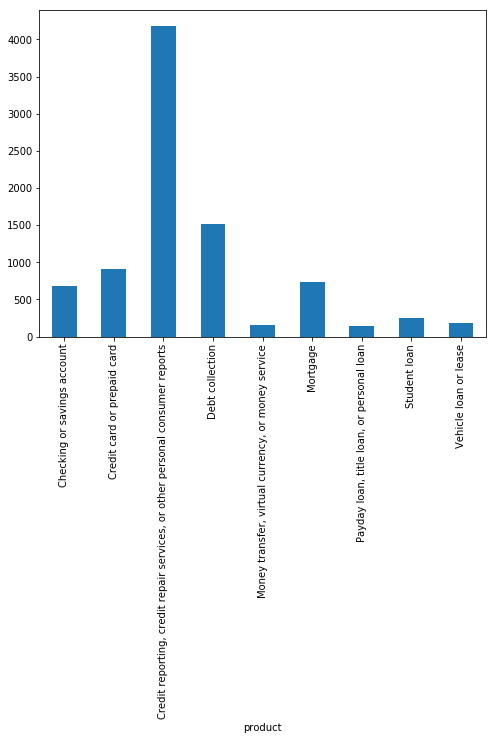

In [8]:
# Lets plot it and see
fig = plt.figure(figsize=(8,6))
Data.groupby('product').consumer_complaint_narrative.count().plot.bar(ylim=0)
plt.show()

In [9]:
train_x, valid_x, train_y, valid_y = model_selection.train_test_split(Data['consumer_complaint_narrative'], Data['product'])

In [10]:
#Step 1-6 Feature engineering using TF-IDF
#Create TF-IDF vectors as we discussed in Chapter 3. Here we consider maximum features to be 5000.
encoder = preprocessing.LabelEncoder()
train_y = encoder.fit_transform(train_y)
valid_y = encoder.fit_transform(valid_y)
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)
tfidf_vect.fit(Data['consumer_complaint_narrative'])
xtrain_tfidf =  tfidf_vect.transform(train_x)
xvalid_tfidf =  tfidf_vect.transform(valid_x)

In [11]:
model = linear_model.LogisticRegression().fit(xtrain_tfidf, train_y)
# Model summary
LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, max_iter=100, multi_class='ovr',
                   n_jobs=1, penalty='l2', random_state=None, solver='liblinear',
                   tol=0.0001, verbose=0, warm_start=False)

/home/username/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/home/username/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [12]:
accuracy = metrics.accuracy_score(model.predict(xvalid_tfidf), valid_y)
print ("Accuracy: ", accuracy)

Accuracy:  0.8153564899451554


In [13]:
# Classification report
print(metrics.classification_report(valid_y, model.predict(xvalid_tfidf),target_names=Data['product'].unique()))

                                                                              precision    recall  f1-score   support

Credit reporting, credit repair services, or other personal consumer reports       0.78      0.82      0.80       177
                                                             Debt collection       0.77      0.69      0.73       217
                                                                    Mortgage       0.83      0.95      0.89      1068
                                                 Checking or savings account       0.77      0.72      0.75       366
                                   Payday loan, title loan, or personal loan       0.78      0.16      0.27        43
                                                 Credit card or prepaid card       0.88      0.85      0.87       187
                          Money transfer, virtual currency, or money service       0.83      0.19      0.30        27
                                                       

In [16]:
#confusion matrix
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(valid_y, model.predict(xvalid_tfidf))

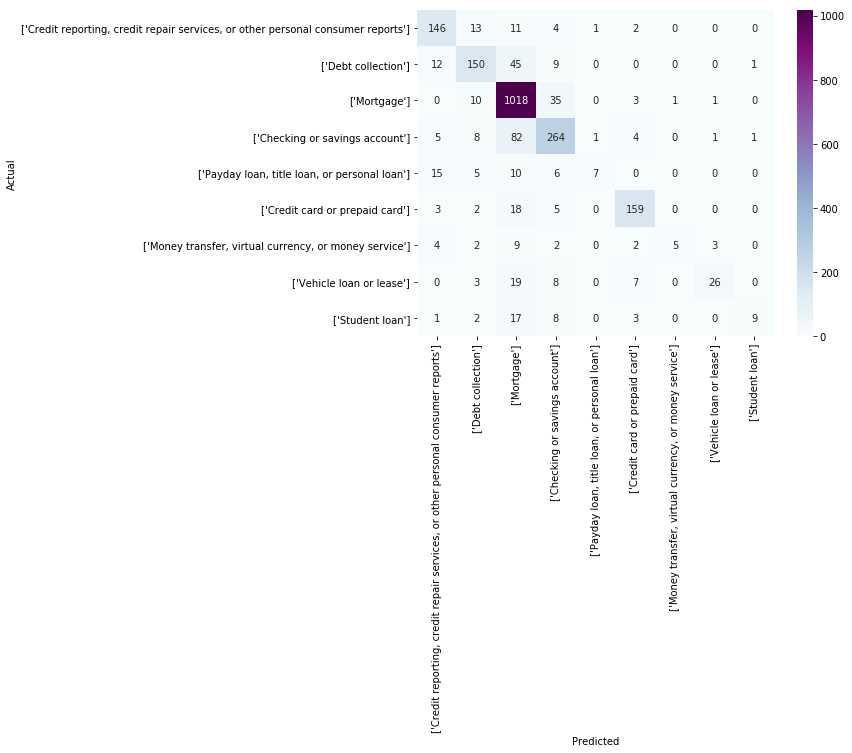

In [17]:
# Vizualizing confusion matrix
category_id_df = Data[['product', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'product']].values)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap="BuPu",
            xticklabels=category_id_df[['product']].values,
            yticklabels=category_id_df[['product']].values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [18]:
# Prediction example
texts = ["This company refuses to provide me verification and validation of debt"+ "per my right under the FDCPA.  I do not believe this debt is mine."]
text_features = tfidf_vect.transform(texts)
predictions = model.predict(text_features)
print(texts)
print("  - Predicted as: '{}'".format(id_to_category[predictions[0]]))

['This company refuses to provide me verification and validation of debtper my right under the FDCPA.  I do not believe this debt is mine.']
  - Predicted as: 'Checking or savings account'
